#  RideFare Analysis - Machine Learning Pipeline

**Objetivo:** Predecir el precio de viajes usando Random Forest Regressor

Este notebook contiene:
1. Conexión y Extracción de datos
2. Limpieza de datos
3. Feature Engineering
4. Entrenamiento del modelo ML
5. Evaluación y visualización de resultados
6. Visualizaciones interactivas con Plotly

##  Celda 1: Importaciones

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
print(" Librerías importadas correctamente")

 Librerías importadas correctamente


##  Celda 2: Función de Conexión y Extracción

In [2]:
def conectar_y_extraer(db_path: str = 'ridefare.db') -> pd.DataFrame:
    """Conecta a SQLite y extrae datos con LEFT JOIN entre rides y weather."""
    conn = sqlite3.connect(db_path)
    query = """
    SELECT r.distance, r.cab_type, r.time_stamp as ride_timestamp, r.destination,
           r.source, r.price, r.surge_multiplier, r.name as ride_name,
           w.temp, w.clouds, w.pressure, w.rain, w.humidity, w.wind
    FROM rides r
    LEFT JOIN weather w ON r.source = w.location
        AND CAST(r.time_stamp / 3600000 AS INTEGER) = CAST(w.time_stamp / 3600 AS INTEGER)
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    print(f" Datos extraídos: {df.shape[0]:,} filas, {df.shape[1]} columnas")
    return df

##  Celda 3: Función de Limpieza

In [3]:
def limpiar_datos(df: pd.DataFrame) -> pd.DataFrame:
    """Limpia el DataFrame eliminando nulos y duplicados."""
    filas_iniciales = len(df)
    df_limpio = df.dropna(subset=['price', 'distance', 'cab_type']).drop_duplicates()
    for col in ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']:
        if col in df_limpio.columns:
            df_limpio[col] = df_limpio[col].fillna(df_limpio[col].median())
    print(f" Limpieza: {filas_iniciales:,} → {len(df_limpio):,} filas")
    return df_limpio

##  Celda 4: Función de Feature Engineering

In [4]:
def preparar_features(df: pd.DataFrame) -> tuple:
    """Prepara features con OneHotEncoding para cab_type."""
    features_num = ['distance', 'surge_multiplier']
    features_clima = [f for f in ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind'] 
                      if f in df.columns and df[f].notna().any()]
    features_num.extend(features_clima)
    
    X_num = df[features_num].values
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cab_encoded = encoder.fit_transform(df[['cab_type']])
    cab_names = [f'cab_{c}' for c in encoder.categories_[0]]
    
    X = np.hstack([X_num, cab_encoded])
    feature_names = features_num + cab_names
    print(f" Features: {len(feature_names)} características")
    return X, df['price'].values, feature_names

##  Celda 5: Función de Entrenamiento

In [5]:
def entrenar_modelo(X, y, test_size=0.2, random_state=42):
    """Entrena Random Forest Regressor."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    modelo = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=5, random_state=random_state, n_jobs=-1)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    print(f" Modelo entrenado: {len(X_train):,} train, {len(X_test):,} test")
    return modelo, X_test, y_test, y_pred

##  Celda 6: Función de Evaluación

In [6]:
def evaluar_y_visualizar(modelo, y_test, y_pred, feature_names):
    """Evalúa modelo y muestra Feature Importance."""
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print("="*50)
    print(f"📊 RMSE: ${rmse:.2f}")
    print(f"📊 R² Score: {r2:.4f} ({r2*100:.1f}% varianza explicada)")
    print("="*50)
    
    # Gráfico Feature Importance
    imp = modelo.feature_importances_
    idx = np.argsort(imp)[::-1]
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(len(imp)), imp[idx], color=plt.cm.viridis(np.linspace(0.2, 0.8, len(imp))))
    ax.set_xticks(range(len(imp)))
    ax.set_xticklabels([feature_names[i] for i in idx], rotation=45, ha='right')
    ax.set_title('🎯 Feature Importance', fontsize=14, fontweight='bold')
    ax.set_xlabel('Features'); ax.set_ylabel('Importancia')
    plt.tight_layout()
    plt.show()
    return {'rmse': rmse, 'r2': r2}

##  Celda 7: Ejecución del Pipeline Completo

🚀 Iniciando Pipeline ML
--------------------------------------------------
 Datos extraídos: 1,269,926 filas, 14 columnas
 Limpieza: 1,269,926 → 597,465 filas
 Features: 10 características
 Modelo entrenado: 477,972 train, 119,493 test
📊 RMSE: $9.00
📊 R² Score: 0.1530 (15.3% varianza explicada)


C:\Users\USER\AppData\Local\Temp\ipykernel_14780\1348177009.py:20: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\USER\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


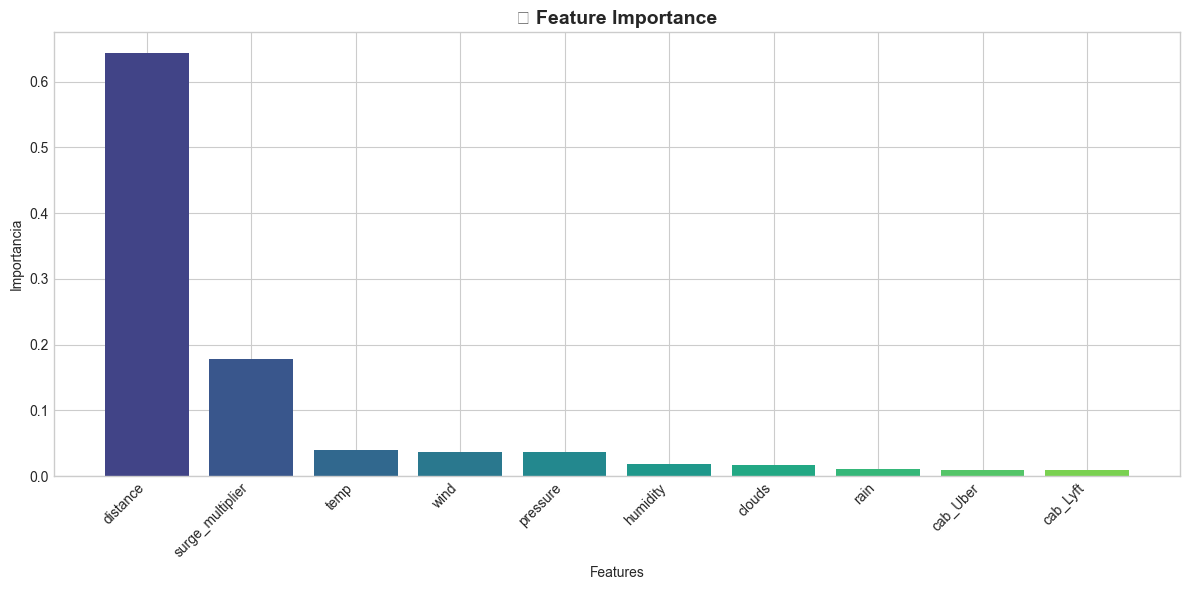

In [7]:
print("🚀 Iniciando Pipeline ML")
print("-" * 50)

# Pipeline completo
df = conectar_y_extraer('ridefare.db')
df_limpio = limpiar_datos(df)
X, y, feature_names = preparar_features(df_limpio)
modelo, X_test, y_test, y_pred = entrenar_modelo(X, y)
metricas = evaluar_y_visualizar(modelo, y_test, y_pred, feature_names)

##  Celda 8: Scatter Plot - Distancia vs Precio por Tipo de Cabina

In [12]:
# Scatter Plot: Distancia vs Precio, coloreado por cab_type
fig_scatter = px.scatter(
    df_limpio.sample(n=min(10000, len(df_limpio)), random_state=42),  # Muestra para rendimiento
    x='distance',
    y='price',
    color='cab_type',
    title=' Distancia vs Precio por Tipo de Cabina',
    labels={'distance': 'Distancia (millas)', 'price': 'Precio ($)', 'cab_type': 'Tipo'},
    opacity=0.6,
    color_discrete_map={'Uber': '#1DB954', 'Lyft': '#FF1493'}
)
fig_scatter.update_layout(
    font=dict(size=12),
    title_font_size=18,
    legend_title_text='Tipo de Cabina'
)
fig_scatter.show()

##  Celda 9: Boxplot - Precio según Condición Climática

In [13]:
# Crear categoría de clima basada en lluvia
df_plot = df_limpio.copy()
df_plot['clima'] = df_plot['rain'].apply(
    lambda x: ' Lluvia' if x > 0.1 else ' Sin Lluvia' if pd.notna(x) else ' Desconocido'
)

# Boxplot: Precio vs Clima
fig_box = px.box(
    df_plot[df_plot['clima'] != ' Desconocido'].sample(n=min(20000, len(df_plot)), random_state=42),
    x='clima',
    y='price',
    color='cab_type',
    title=' Precio según Condición Climática',
    labels={'clima': 'Condición Climática', 'price': 'Precio ($)', 'cab_type': 'Tipo'},
    color_discrete_map={'Uber': '#1DB954', 'Lyft': '#FF1493'}
)
fig_box.update_layout(
    font=dict(size=12),
    title_font_size=18,
    legend_title_text='Tipo de Cabina'
)
fig_box.show()

##  Celda 10: Feature Importance Interactivo

In [14]:
# Feature Importance con Plotly
imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': modelo.feature_importances_
}).sort_values('Importance', ascending=True)

fig_imp = px.bar(
    imp_df,
    x='Importance',
    y='Feature',
    orientation='h',
    title='🎯 Feature Importance - Random Forest',
    color='Importance',
    color_continuous_scale='Viridis'
)
fig_imp.update_layout(
    font=dict(size=12),
    title_font_size=18,
    showlegend=False,
    yaxis_title='',
    xaxis_title='Importancia'
)
fig_imp.show()

---
##  Resumen Final

**Pipeline completado exitosamente:**
- 📥 Datos extraídos de SQLite con JOIN
- 🧹 Datos limpiados
- ⚙️ Features preparados con OneHotEncoding
- 🤖 Modelo Random Forest entrenado
- 📊 Métricas y visualizaciones generadas

In [11]:
print("🎉 ¡Análisis completado!")
print(f"📊 RMSE Final: ${metricas['rmse']:.2f}")
print(f"📊 R² Score: {metricas['r2']:.4f}")

🎉 ¡Análisis completado!
📊 RMSE Final: $9.00
📊 R² Score: 0.1530
